# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## План исследования

### Предварительный осмотр данных:

- соберем общую информацию о данных 
- оценим нехватку или избыточность данных
- определим явно некорректные данные

### Предобработка данных

- определим и заполним пропущенные значения
- заменим типы данных для оптимизации хранения датасет в оперативной памяти
- удалим дубликаты
- проведем категоризацию данных

### Вопросы - на которые небходимо найти ответы в ходе анализа данных:

- Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.

- Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

- Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.

- Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

### **Составить общий вывод**



### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

In [36]:
#!pip3 install Seaborn
import seaborn as sns

In [40]:
local = False
if local: 
    df = pd.read_csv('./datasets/real_estate_data.csv','\t') 
else:
    # чтение с googl диска
    url = "https://drive.google.com/file/d/1nQuTDENKhfqw76p1Wrji4AhDIM3U1MKn/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    df = pd.read_csv(path,sep='\t')

In [43]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [ ]:
df.sample(5)

#### Описание данных
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [54]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


In [55]:
# оценим количество NaN в разных колонках
def Columns_with_NaN(dataframe):
    SeriesNaN =  dataframe.isnull().sum().sort_values()
    for column in SeriesNaN.index:
        if SeriesNaN[column]==0:
            continue 
        print('{:<20}| NaN = {:<7}| {:^10.1%}'.format(column,SeriesNaN[column],SeriesNaN[column]/dataframe.shape[0]))
    
Columns_with_NaN(df)

locality_name       | NaN = 49     |    0.2%   
floors_total        | NaN = 86     |    0.4%   
living_area         | NaN = 1903   |    8.0%   
kitchen_area        | NaN = 2278   |    9.6%   
days_exposition     | NaN = 3181   |   13.4%   
ponds_around3000    | NaN = 5518   |   23.3%   
parks_around3000    | NaN = 5518   |   23.3%   
cityCenters_nearest | NaN = 5519   |   23.3%   
airports_nearest    | NaN = 5542   |   23.4%   
ceiling_height      | NaN = 9195   |   38.8%   
balcony             | NaN = 11519  |   48.6%   
ponds_nearest       | NaN = 14589  |   61.6%   
parks_nearest       | NaN = 15620  |   65.9%   
is_apartment        | NaN = 20924  |   88.3%   


### Вывод

- много данных с NaN 
- "затратные по потребляемой памяти типы данных", например в колонках: is_apartment, locality_name          
- присутствует верхний и нижний регистр в названии столбцов
- колонка 'цена на момент снятия с публикации' - last_price,  минимум в 12190.0 руб. Подозрительно!
- ключевые столбцы переместить к левому краю, так как неудобно смотреть 
- есть записи с высотой потолка в 100 метров. Подозрительно!


### Шаг 2. Предобработка данных

In [56]:
#уберем верний регистр из названий колонок
#генерируем словарь из названий колонок датасета
dictionary = {column: column.lower() for column in df.columns}

#переименовываем колонки по полученному словарю.
df = df.rename(columns=dictionary)

#вручную меняем порядок колонок, первыми пойдут ключевые характеристики
string_columns = 'locality_name,rooms,floor,floors_total,living_area,kitchen_area,total_area,'
string_columns += 'ceiling_height,balcony,studio,is_apartment,open_plan,total_images,'
string_columns += 'citycenters_nearest,parks_nearest,parks_around3000,ponds_nearest,ponds_around3000,airports_nearest,'
string_columns += 'first_day_exposition,days_exposition,last_price'

list_columns = string_columns.split(',')

df=df[list_columns]

In [57]:
#смотрим что получилось
df.head(1)

,locality_name,rooms,floor,floors_total,living_area,kitchen_area,total_area,ceiling_height,balcony,studio,...,total_images,citycenters_nearest,parks_nearest,parks_around3000,ponds_nearest,ponds_around3000,airports_nearest,first_day_exposition,days_exposition,last_price
0,Санкт-Петербург,3,8,16.0,51.0,25.0,108.0,2.7,NaN,False,...,20,16028.0,482.0,1.0,755.0,2.0,18863.0,2019-03-07T00:00:00,NaN,13000000.0


In [58]:
print('Всего населенных пунктов =  {}'.format(len(df['locality_name'].unique())))

Всего населенных пунктов =  365


In [59]:
# разберемся с населенными пунктами

# названия переводим в нижний регистр
df['locality_name'] = df['locality_name'].str.lower()

#смотрим
df['locality_name'].unique().tolist()

['санкт-петербург',
 'посёлок шушары',
 'городской посёлок янино-1',
 'посёлок парголово',
 'посёлок мурино',
 'ломоносов',
 'сертолово',
 'петергоф',
 'пушкин',
 'деревня кудрово',
 'коммунар',
 'колпино',
 'поселок городского типа красный бор',
 'гатчина',
 'поселок мурино',
 'деревня фёдоровское',
 'выборг',
 'кронштадт',
 'кировск',
 'деревня новое девяткино',
 'посёлок металлострой',
 'посёлок городского типа лебяжье',
 'посёлок городского типа сиверский',
 'поселок молодцово',
 'поселок городского типа кузьмоловский',
 'садовое товарищество новая ропша',
 'павловск',
 'деревня пикколово',
 'всеволожск',
 'волхов',
 'кингисепп',
 'приозерск',
 'сестрорецк',
 'деревня куттузи',
 'посёлок аннино',
 'поселок городского типа ефимовский',
 'посёлок плодовое',
 'деревня заклинье',
 'поселок торковичи',
 'поселок первомайское',
 'красное село',
 'посёлок понтонный',
 'сясьстрой',
 'деревня старая',
 'деревня лесколово',
 'посёлок новый свет',
 'сланцы',
 'село путилово',
 'ивангород',
 '

In [60]:
# в слове 'поселок' прыгает буква е = ё
# заменим на е
df['locality_name'] = df['locality_name'].str.replace('ё', 'е', regex=True)

In [61]:
# locality_name       | NaN = 49     |    0.2% 
# удалим строки с пропущенным населенным пунктом, так как таких строк 0.2%, см. оценку выше.

# плохо
#df.dropna(subset=['locality_name'],inplace = True) 
#хорошо
df = df.dropna(subset=['locality_name']) 

len(df)

23650

In [62]:
# количество населенных пунктов после преобразования
print('Всего населенных пунктов =  {}'.format(len(df['locality_name'].unique())))
#сократилось на 30 пунктов

Всего населенных пунктов =  330


In [64]:
# колонка апартаменты
# nan преобразуем в False
df['is_apartment'] = df['is_apartment'].astype('bool')
df['is_apartment'].unique()

array([ True, False])

In [65]:
# отсутствующее значение по колонке 'балкон' заменим на 0, то есть предположим, что балкон отсутствует
df['balcony'] = df['balcony'].fillna(0)

# days_exposition меняется от 1 до 1580.0, поэтому без потери данных можно заменить на 0
df['days_exposition'] = df['days_exposition'].fillna(0)

In [66]:
# преобразуем колонки с числовыми типами
df.astype({ "last_price": "int64", "balcony": "int", "days_exposition" : \
           "int", "rooms" : "int", "total_area" : "int"}).info()

# так как для преобразования типов, приходится или удалять NaN или заполнять пропуски чем-то,
# что в свою очеред приведет к искажению данных, то остальные колонки не будем трогать:
# ceiling_height, floors_total, living_area, kitchen_area, parks_nearest, citycenters_nearest, parks_around3000, ponds_nearest
# ponds_around3000, airports_nearest


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
locality_name           23650 non-null object
rooms                   23650 non-null int64
floor                   23650 non-null int64
floors_total            23565 non-null float64
living_area             21752 non-null float64
kitchen_area            21381 non-null float64
total_area              23650 non-null int64
ceiling_height          14490 non-null float64
balcony                 23650 non-null int64
studio                  23650 non-null bool
is_apartment            23650 non-null bool
open_plan               23650 non-null bool
total_images            23650 non-null int64
citycenters_nearest     18139 non-null float64
parks_nearest           8064 non-null float64
parks_around3000        18140 non-null float64
ponds_nearest           9085 non-null float64
ponds_around3000        18140 non-null float64
airports_nearest        18116 non-null float64
first_day_exposition

In [67]:
# преобразуем колонку 'first_day_exposition' из строки в дату
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'],format='%Y-%m-%d') #format='%Y-%m-%dT%H:%M:%S'

In [68]:
# переведем в километры все дистанции

df['ponds_nearest'] = df['ponds_nearest'] / 1000
df['airports_nearest'] = df['airports_nearest'] / 1000
df['parks_nearest'] = df['parks_nearest'] / 1000
df['ponds_around3000'] = df['ponds_around3000'] / 1000
df['parks_around3000'] = df['parks_around3000'] / 1000
df['citycenters_nearest'] = df['citycenters_nearest'] / 1000


In [69]:
# так как расстояние до центра санкт-перербурга, является одним из ключевых полей попробуем восстановить пропуски
# попытаемся собрать таблицу расстояний от ценра санкт-пертербург по населенным пунктым, исключая сам санкт-пертербург

df_distance_citycenters=df.loc[(~df['citycenters_nearest'].isna()) & ((df['locality_name'] !='санкт-петербург')) ]
df_distance_citycenters = pd.pivot_table(df, values='citycenters_nearest', index=['locality_name'],  \
                                         aggfunc=['min','max','median'])
df_distance_citycenters.columns = ['min','max','median']
df_distance_citycenters.head(5)


,min,max,median
locality_name,,,
зеленогорск,51.115,62.706,53.3810
колпино,29.436,37.477,32.0180
красное село,27.317,41.792,29.1405
кронштадт,46.657,51.511,49.5750
ломоносов,36.816,61.495,51.6770


In [70]:
#получим список населенных пунктов с NaN в колонке citycenters_nearest
df_bad_citycenters_nearest= df.loc[(df['citycenters_nearest'].isna()) & ((df['locality_name'] !='санкт-петербург')) ]
bad_list_citycenters_nearest = df_bad_citycenters_nearest['locality_name'].unique().tolist()

#оценим возможность замены, через срез по таблице с расстояниями для списка плохих населенных пунктов
df_distance_citycenters.query('locality_name in @bad_list_citycenters_nearest')

#в восьми населенных пунктах можно восстановить медианное расстояние до центра СПб

,min,max,median
locality_name,,,
колпино,29.436,37.477,32.0180
красное село,27.317,41.792,29.1405
кронштадт,46.657,51.511,49.5750
ломоносов,36.816,61.495,51.6770
поселок мурино,21.888,21.888,21.8880
поселок шушары,17.012,32.079,24.2120
поселок щеглово,34.085,34.085,34.0850
пушкин,24.311,35.610,27.9305


In [71]:
# до подмены было
count_NaN_before = len(df.loc[(df['citycenters_nearest'].isna()) & ((df['locality_name'] !='санкт-петербург')) ])
print('Количество строк с NaN по колонке citycenters_nearest = {}'.format(count_NaN_before))

Количество строк с NaN по колонке citycenters_nearest = 5450


In [72]:
#функция подменяет NaN в строке по имеющейся таблице расстояний

def calculate_citycenters_distance(raw):
    
    dff = df_distance_citycenters 
    
    locality_name = raw['locality_name']
    
    #if raw['distance_citycenters'] == np.nan: # <- не работает
    
    if str(raw['citycenters_nearest'])==str(np.nan):
        dff = dff.loc[dff.index == locality_name]
        if len(dff)==1:
            return dff['median'].tolist()[0] # <- вот так добирался до цифры, через список. df.loc[1] - не получилось
        else:
             return raw['citycenters_nearest']
    else: 
        return raw['citycenters_nearest']

In [73]:
df['distance_citycenters'] = df.apply(calculate_citycenters_distance, axis=1) 

In [74]:
# после подмены получили 
count_NaN_after = len(df.loc[(df['distance_citycenters'].isna()) & ((df['locality_name'] !='санкт-петербург')) ])
print('Количество строк с NaN по колонке distance_citycenters = {}'.format(count_NaN_after))
print('Восстановлено {} NaN'.format(count_NaN_before - count_NaN_after))

Количество строк с NaN по колонке distance_citycenters = 4864
Восстановлено 586 NaN


In [75]:
# восстановим расстояние до аэрапорта по такому же алгоритму

#соберем данные
df_distance_airports =df.loc[(~df['airports_nearest'].isna()) & ((df['locality_name'] !='санкт-петербург')) ]
df_distance_airports = pd.pivot_table(df_distance_airports, values='airports_nearest', index=['locality_name'],  aggfunc=['min','max','median'])
df_distance_airports.columns = ['min','max','median']
df_distance_airports.head(5)

,min,max,median
locality_name,,,
зеленогорск,70.016,81.607,72.2820
колпино,23.649,31.691,26.2320
красное село,23.892,38.367,25.7155
кронштадт,64.931,69.785,67.8500
ломоносов,46.502,56.896,48.4155


In [76]:
#функция подменяет NaN в строке по имеющейся таблице расстояний

def calculate_airports_distance(raw):
    
    df_temp = df_distance_airports 
    
    locality_name = raw['locality_name']
    
    #if raw['distance_citycenters'] == np.nan: # <- не работает
    
    if str(raw['airports_nearest'])==str(np.nan): # <- а так работает
        
        df_temp = df_temp.loc[df_temp.index == locality_name]
        if len(df_temp)==1:
            return df_temp['median'].tolist()[0] # <- вот так добирался до цифры, через список в обход. конструкция df.loc[1,'median'] - не сработала
        else:
             return raw['airports_nearest']
    else: 
        return raw['airports_nearest']

In [77]:
df['distance_airports'] = df.apply(calculate_airports_distance, axis=1) 

In [78]:
# оценим количество пропусков до восстановления  
len(df.loc[(df['airports_nearest'].isna()) & ((df['locality_name'] !='санкт-петербург')) ])

5449

In [79]:
# оценим количество пропусков после восстановления 
len(df.loc[(df['distance_airports'].isna()) & ((df['locality_name'] !='санкт-петербург')) ])

4864

In [80]:
Columns_with_NaN(df)

floors_total        | NaN = 85     |    0.4%   
living_area         | NaN = 1898   |    8.0%   
kitchen_area        | NaN = 2269   |    9.6%   
distance_citycenters| NaN = 4864   |   20.6%   
distance_airports   | NaN = 4949   |   20.9%   
parks_around3000    | NaN = 5510   |   23.3%   
ponds_around3000    | NaN = 5510   |   23.3%   
citycenters_nearest | NaN = 5511   |   23.3%   
airports_nearest    | NaN = 5534   |   23.4%   
ceiling_height      | NaN = 9160   |   38.7%   
ponds_nearest       | NaN = 14565  |   61.6%   
parks_nearest       | NaN = 15586  |   65.9%   


In [81]:
# 38% строк с незаполненным потолком. Выбрасывать такие строки нельзя

# пропуски в высоте потолка заменим на медиану
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

In [82]:
#проверяем дубли
df.duplicated().sum()

0

### Шаг 3. Посчитайте и добавьте в таблицу

In [83]:
# цена квадратного метра
try:
    df['price_per_meter'] = df['last_price'] / df['total_area']
except:
    print('Деление на ноль!')

In [84]:
#день недели, месяц и год публикации объявления

dictionary_weekday = {1:'Понедельник',2:'Вторник',3:'Среда',4:'Четверг',5:'Пятница',6:'Суббота',7:'Воскресение'}
df['weekday_exposition_str'] = df['first_day_exposition'].dt.weekday.map(dictionary_weekday)
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday

dictionary_month = {1:'Январь',2:'Февраль',3:'Март',4:'Апрель',5:'Май',6:'Июнь',7:'Июль',8:'Август',9:'Сентябрь',10:'Октябрь',11:'Ноябрь',12:'Декабрь',}
df['month_exposition_str'] = df['first_day_exposition'].dt.month.map(dictionary_month)
df['month_exposition'] = df['first_day_exposition'].dt.month 

df['year_exposition'] = df['first_day_exposition'].dt.year
#df.head(3)

In [85]:
# этаж квартиры; варианты — первый, последний, другой;
def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
df['floor_category'] = df.apply(floor_category, axis=1)

In [86]:
#соотношение жилой и общей площади, а также отношение площади кухни к общей.

try:
    df['living_area_vs_total_area'] = df['living_area'] / df['total_area']
except:
    print('Деление на ноль!')

try:
    df['kitchen_area_vs_total_area'] = df['kitchen_area'] / df['total_area']
except:
    print('Деление на ноль!')

#len(df.loc[df['total_area']==0])
len(df.loc[df['total_area'].isna()])

0

In [87]:
df.head(5)

,locality_name,rooms,floor,floors_total,living_area,kitchen_area,total_area,ceiling_height,balcony,studio,...,distance_airports,price_per_meter,weekday_exposition_str,weekday_exposition,month_exposition_str,month_exposition,year_exposition,floor_category,living_area_vs_total_area,kitchen_area_vs_total_area
0,санкт-петербург,3,8,16.0,51.0,25.0,108.0,2.70,0.0,False,...,18.863,120370.370370,Среда,3,Март,3,2019,другой,0.472222,0.231481
1,поселок шушары,1,1,11.0,18.6,11.0,40.4,2.65,2.0,False,...,12.817,82920.792079,Понедельник,1,Декабрь,12,2018,первый,0.460396,0.272277
2,санкт-петербург,2,4,5.0,34.3,8.3,56.0,2.65,0.0,False,...,21.741,92785.714286,Среда,3,Август,8,2015,другой,0.612500,0.148214
3,санкт-петербург,3,9,14.0,NaN,NaN,159.0,2.65,0.0,False,...,28.098,408176.100629,Четверг,4,Июль,7,2015,другой,NaN,NaN
4,санкт-петербург,2,13,14.0,32.0,41.0,100.0,3.03,0.0,False,...,31.856,100000.000000,Понедельник,1,Июнь,6,2018,другой,0.320000,0.410000


In [88]:
#df.describe().T

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

### Задача: Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра

In [89]:
#составим словарь с интересующими колонками

columns_dict = {'total_area':'площадь квартиры в квадратных метрах (м²)', 
                'last_price':'цена на момент снятия с публикации',
                'rooms':'число комнат',
                'ceiling_height':'высота потолков',
                'days_exposition':'сколько дней было размещено объявление (от публикации до снятия)',
}

xlabel_dict = {'total_area':'м²', 
                'last_price':'руб',
                'rooms':'количество',
                'ceiling_height':'метры',
                'days_exposition':'дни',
}

In [90]:
list_columns = list(columns_dict) # ['total_area', 'last_price', 'rooms', 'ceiling_height']

In [91]:
#оценим и запомним
before = df[list_columns].describe().T
before

,count,mean,std,min,25%,50%,75%,max
total_area,23650.0,6.032907e+01,3.566181e+01,12.0,40.0,52.00,69.7,900.0
last_price,23650.0,6.541127e+06,1.089640e+07,12190.0,3400000.0,4650000.00,6799000.0,763000000.0
rooms,23650.0,2.070106e+00,1.078620e+00,0.0,1.0,2.00,3.0,19.0
ceiling_height,23650.0,2.724311e+00,9.892549e-01,1.0,2.6,2.65,2.7,100.0
days_exposition,23650.0,1.564490e+02,2.135645e+02,0.0,22.0,73.00,198.0,1580.0


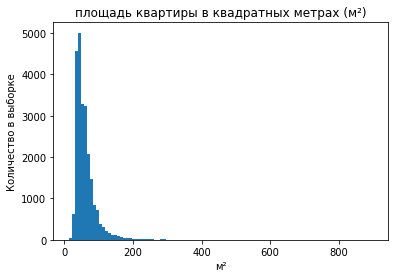

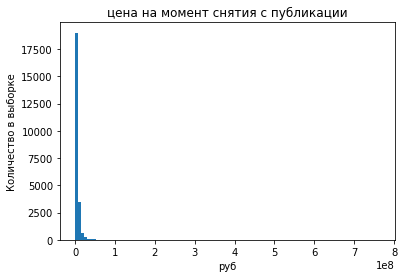

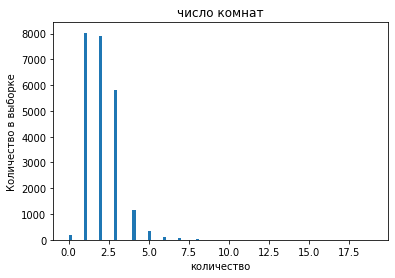

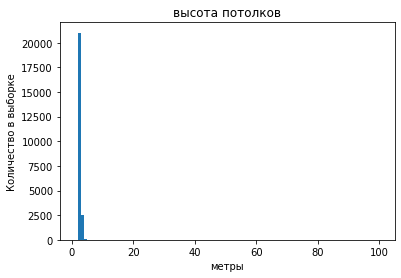

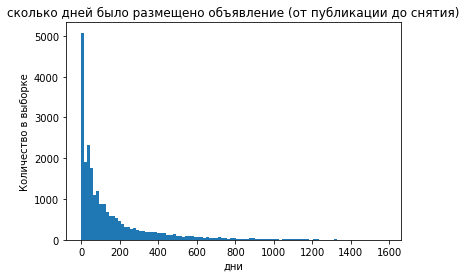

In [92]:
# первоначальный осмотр
for column in columns_dict:
    plt.show()
    df[column].plot(y=column, title = columns_dict[column], kind = 'hist', bins=100)
    plt.ylabel('Количество в выборке')
    plt.xlabel(xlabel_dict[column])
    

Построенные гистограммы показывают, что есть неправдоподобные значения на максимумах

In [93]:
#уберем хвосты на гистограммах через параметр range

# функция возвращает межквартильный размах для колонки в виде кортежа
def generate_range(column):
    
    Q25 = df[column].quantile(0.25)                 
    Q75 = df[column].quantile(0.75) 
    MIN = df[column].min()
    MAX = df[column].max()
    
    IQR = Q75 - Q25
    
    left = Q25 - 1.5*IQR
    if left < MIN: left = MIN
    
    Right = Q75 + 1.5*IQR
    if Right > MAX: Right = MAX
     
    return (left, Right)


In [94]:
#generate_range('ceiling_height')

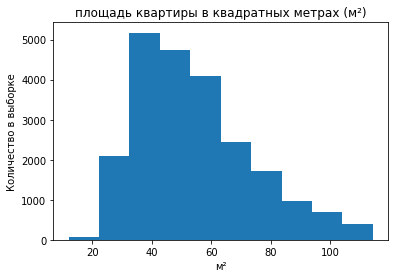

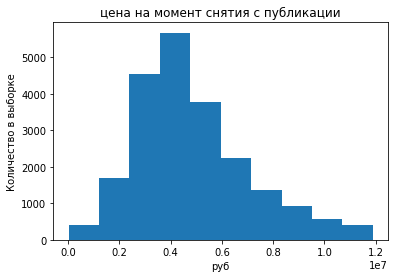

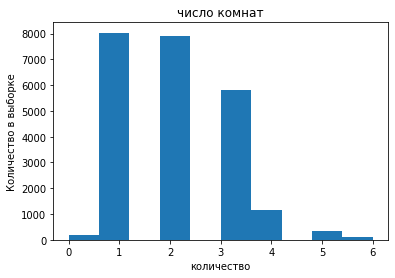

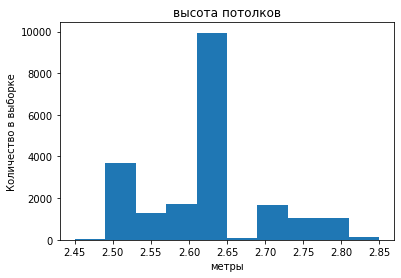

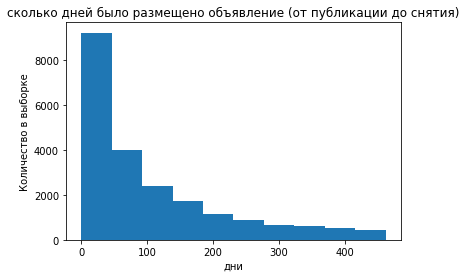

In [95]:
for column in columns_dict:
    plt.show()
    df[column].plot(y=column, title = columns_dict[column], kind = 'hist', bins=10, range=generate_range(column))
    plt.ylabel('Количество в выборке')
    plt.xlabel(xlabel_dict[column])

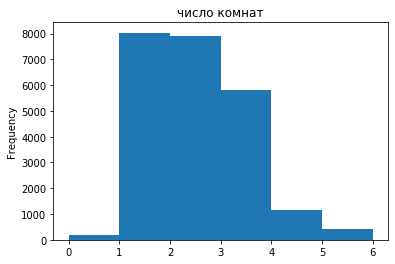

In [96]:
#гистограмму с комнатами перерисуем аккуратнее, подправив bins=6
column = 'rooms'
df[column].plot(y=column, title = columns_dict[column], kind = 'hist', bins=6, range=generate_range(column))

**Вывод: Гистограммы с исключенными экстремальными значениями имеют более привлекательный вид. Необходимо удалить из данных редкие и выбивающиеся значения, ограничив их межквартильным размахом.**

In [97]:
# алгоритм исключения экстремальных значений. Цикл по колонкам, взятие среза по квартилям и перезапись
for column in columns_dict:
    tuple_range = generate_range(column)
    left_range = tuple_range[0]
    right_range = tuple_range[1]
    sql_sentence='@left_range <= '+ column + ' and '+ column + ' <= @right_range'
    #print(sql_sentence)
    #break
    df_temp = df.query(sql_sentence)
    df = df_temp.copy()
    del df_temp

Итого:


In [98]:
# посмотрим, что получилось после очистки от выбросов
after = df[list_columns].describe().T
after

,count,mean,std,min,25%,50%,75%,max
total_area,12527.0,5.099100e+01,1.671912e+01,12.00,38.00,47.00,61.10,114.20
last_price,12527.0,4.513082e+06,1.913816e+06,430000.00,3200000.00,4200000.00,5580000.00,10700000.00
rooms,12527.0,1.843937e+00,8.725184e-01,0.00,1.00,2.00,2.00,5.00
ceiling_height,12527.0,2.639507e+00,3.814104e-02,2.53,2.65,2.65,2.65,2.72
days_exposition,12527.0,1.002864e+02,1.030045e+02,0.00,23.00,60.00,146.00,430.00


In [99]:
# вот так было до очистки выбросов
before

,count,mean,std,min,25%,50%,75%,max
total_area,23650.0,6.032907e+01,3.566181e+01,12.0,40.0,52.00,69.7,900.0
last_price,23650.0,6.541127e+06,1.089640e+07,12190.0,3400000.0,4650000.00,6799000.0,763000000.0
rooms,23650.0,2.070106e+00,1.078620e+00,0.0,1.0,2.00,3.0,19.0
ceiling_height,23650.0,2.724311e+00,9.892549e-01,1.0,2.6,2.65,2.7,100.0
days_exposition,23650.0,1.564490e+02,2.135645e+02,0.0,22.0,73.00,198.0,1580.0


**Вывод:**

В датасете удалены неправлоподобные значения. Например: 

--кваритры, где потолки высотой в 1 или 100 метров, 

--квартиры в 19 комнат и площадью 900 м. 

--квартиры по цене 12 000 руб и 700 000 000 руб



### Задача: Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?


Text(0.5, 0, 'Дни')

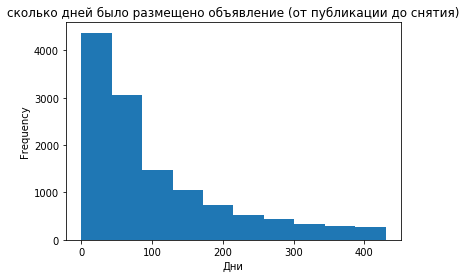

In [100]:
column = 'days_exposition'
df[column].plot(y=column, title = columns_dict[column], kind = 'hist', bins=10) 
plt.xlabel('Дни')

In [101]:
df[column].describe().T

count    12527.000000
mean       100.286421
std        103.004512
min          0.000000
25%         23.000000
50%         60.000000
75%        146.000000
max        430.000000
Name: days_exposition, dtype: float64

##### Вывод: За среднее время продаж примем медианное значение = 60 дней. Соответственно будем считать, что продажа прошла быстро если она заняла менее месяца месяца (это 25% всех продаж). Необычно долгие продажи - это продажи время которых превышает 140 дней (это значение третьего квартиля). Экстремально долгие продажи от 300 дней и более - до 1500 дней.

### Задача: Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.

In [102]:
# построим таблицу корреляции для цены
corr = df[['last_price','total_area','rooms','days_exposition','distance_citycenters',]].corr() #price_per_meter
corr.style.background_gradient('coolwarm') 

,last_price,total_area,rooms,days_exposition,distance_citycenters
last_price,1,0.670077,0.438794,0.00580475,-0.3198
total_area,0.670077,1,0.818529,0.0461159,-0.069592
rooms,0.438794,0.818529,1,0.0325764,-0.0542371
days_exposition,0.00580475,0.0461159,0.0325764,1,0.029019
distance_citycenters,-0.3198,-0.069592,-0.0542371,0.029019,1


In [103]:
# построим таблицу корреляции для цены за квадратный метр площади
corr = df[['price_per_meter','total_area','rooms','days_exposition','distance_citycenters']].corr() #price_per_meter
corr.style.background_gradient('coolwarm') 

,price_per_meter,total_area,rooms,days_exposition,distance_citycenters
price_per_meter,1,-0.139416,-0.258178,-0.038975,-0.409649
total_area,-0.139416,1,0.818529,0.0461159,-0.069592
rooms,-0.258178,0.818529,1,0.0325764,-0.0542371
days_exposition,-0.038975,0.0461159,0.0325764,1,0.029019
distance_citycenters,-0.409649,-0.069592,-0.0542371,0.029019,1


Text(0, 0.5, 'Цена за квадратный метр')

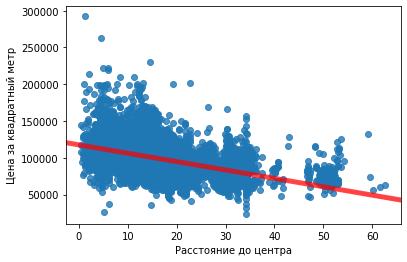

In [104]:
# оценим зависимость цены за квадратный метр от расстояния до центра
sns.regplot(x=df["distance_citycenters"], y=df["price_per_meter"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlabel('Расстояние до центра')
plt.ylabel('Цена за квадратный метр')

##### Вывод: С увеличением расстояния от центра падает цена за квадратный метр. На графике видно падение за квадратный метр цены со 100 000 руб в центре 10 км радиуса до 50 000 руб при удалении на 60 км от центра

Text(0, 0.5, 'Цена за квадратный метр')

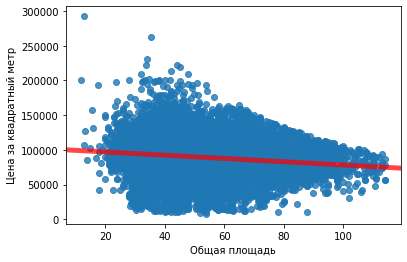

In [105]:
# оценим зависимость общей площади и цены за квадратный метр
sns.regplot(x=df["total_area"], y=df["price_per_meter"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlabel('Общая площадь')
plt.ylabel('Цена за квадратный метр')

#### Вывод: С увеличением площади квартиры падает цена за квадратный метр. Падение может составить до четверти цены! На графике видно, что цена со 100 000 руб за квадратный метр для общей площади 20-30 метров квадратных может упасть до 75 000 руб с ростом общей площади до 100 квадратных метров

Text(0, 0.5, 'Цена за квадратный метр')

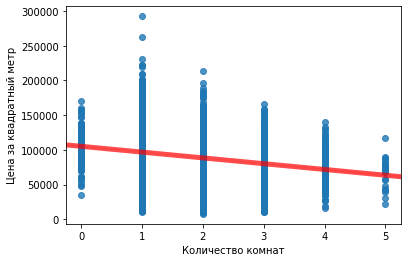

In [106]:
sns.regplot(x=df["rooms"], y=df["price_per_meter"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlabel('Количество комнат')
plt.ylabel('Цена за квадратный метр')

##### Вывод: Однокомнатные квартиры ценятся выше всего за квадратный метр. На графике видно, что цена может снизиться на четверть с ростом количества комнат

In [107]:
#оценим зависимость цены от этажности
pivot_table = pd.pivot_table(df, values='price_per_meter', index=['floor_category'],  aggfunc=['max','median'])
pivot_table.columns = ['max','median']
pivot_table

,max,median
floor_category,,
другой,292307.692308,94500.506497
первый,196078.431373,77586.206897
последний,200000.000000,81262.860082


Text(0, 0.5, 'Цена за квадратный метр')

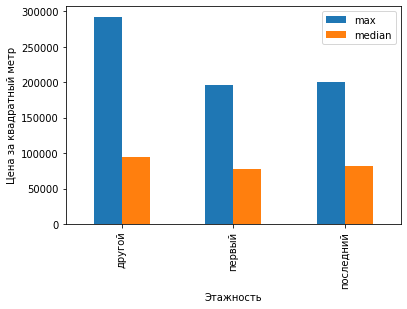

In [108]:
pivot_table.plot(kind="bar");
plt.xlabel('Этажность')
plt.ylabel('Цена за квадратный метр')

In [109]:
# в процентах
100 - pivot_table['median'].первый / pivot_table['median'].другой * 100

17.898633803794596

##### Вывод: Первый и последниий этажи не пользуются спросом по сравнению со средними этажами. Падение в цене за квадратный метр может составить 18%

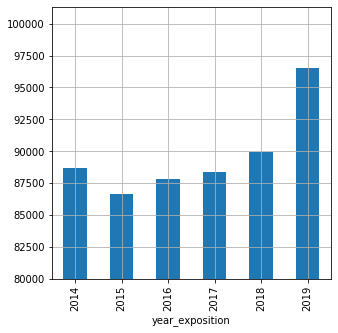

In [110]:
#построим гистограмму по годам публикации
df_year = df.groupby('year_exposition')['price_per_meter'].mean()
df_year.plot(kind='bar',ylim=80000,grid=True,figsize=(5,5))

In [111]:
# оценим динамику изменения в %

year_list = df['year_exposition'].unique().tolist()
year_list.sort()

for y in year_list: #[2014,2015,2016,2017,2018]:
    if year_list.index(y)==len(year_list)-1:
        continue
    print('Ежегодный прирост цены за квадратный метр в {}  = {:.1%} '.format(y+1, 1 - df_year[y]/df_year[y+1]))


Ежегодный прирост цены за квадратный метр в 2015  = -2.4% 
Ежегодный прирост цены за квадратный метр в 2016  = 1.3% 
Ежегодный прирост цены за квадратный метр в 2017  = 0.6% 
Ежегодный прирост цены за квадратный метр в 2018  = 1.8% 
Ежегодный прирост цены за квадратный метр в 2019  = 6.8% 


##### Вывод: Цены были достаточно стабильны с 2015 по 2018 год. Колебания цены были около 2%.  Но в 2019 году цены начились резко подниматься. Ежегодны прирост стал равен 6.8%. 

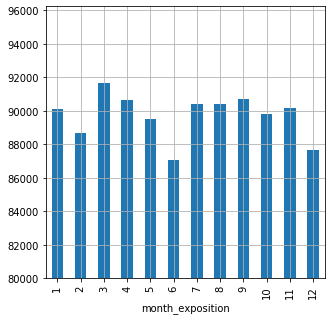

In [112]:
df_month = df.groupby('month_exposition')['price_per_meter'].mean()
df_month.plot(kind='bar',ylim=80000,grid=True,figsize=(5,5))

In [113]:
# оценим разницу 3 и 6 месяцев, как наиболее показательных
print('Оценка колебаний цены на квадратный месяц помесячно может составить = {:.1%} '.format((1 - df_month[6]/df_month[3])))

Оценка колебаний цены на квадратный месяц помесячно может составить = 5.0% 


##### Вывод: В июле(7) и в декабре(12) видны минимумы. Но колебания цен не более 5%.

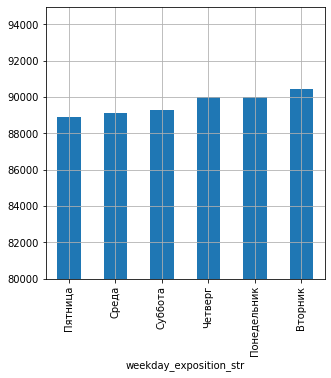

In [114]:
#колебания цен по дням недели
df_weekday = df.groupby('weekday_exposition_str')['price_per_meter'].mean()
#df_weekday.sort_values()
df_weekday.sort_values().plot(kind='bar',ylim=80000,grid=True,figsize=(5,5))

In [115]:
# оценим 3 и 2 дни, как наиболее показательные
(1 - df_weekday['Пятница']/df_weekday['Вторник'])*100
print('Оценка колебаний цены на квадратный месяц по дням недели = {:.1%} '.format(1 - df_weekday['Пятница']/df_weekday['Вторник']))

Оценка колебаний цены на квадратный месяц по дням недели = 1.7% 


##### Вывод: Почти нет зависимости. Всего 1.8% разницы между пятницей и вторником. В пятницу цены минимальные, возможно объявление составляется небрежно.

### Задача: Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.


In [116]:
# количество объявлений

name_10 = df.groupby('locality_name')['price_per_meter'].count()
name_10 = name_10.sort_values().tail(10)
name_10

locality_name
выборг                148
гатчина               182
пушкин                185
колпино               190
деревня кудрово       198
всеволожск            258
поселок парголово     274
поселок шушары        338
поселок мурино        421
санкт-петербург      7577
Name: price_per_meter, dtype: int64

In [117]:
 dff = df.loc[df['locality_name'].isin(name_10.index)]

In [118]:
pivot_table =  pd.pivot_table(dff, values='price_per_meter', index=['locality_name'],  aggfunc=['std'])
pivot_table.columns = ['price_per_meter']
pivot_table

,price_per_meter
locality_name,
всеволожск,11059.036628
выборг,12117.834454
гатчина,14137.618488
деревня кудрово,11752.769096
колпино,10987.562632
поселок мурино,14281.419544
поселок парголово,17143.134641
поселок шушары,14906.136076
пушкин,15433.571873


Text(0, 0.5, 'Цена')

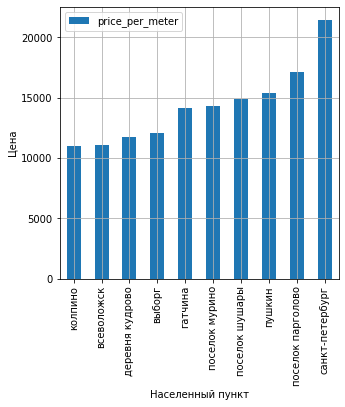

In [119]:
pivot_table.sort_values(by ='price_per_meter').plot(kind='bar',xlim=10000,grid=True,figsize=(5,5))
plt.title('')
plt.xlabel('Населенный пункт')
plt.ylabel('Цена')

##### Вывод: Наибольшайя цена за квадратный метр жилья в Санкт Питербурге, что и следовало ожидать. Далее идет Пушкин. И минимальная цена в топ-10 это Всеволожск. Разница в цене почти в два раза. Спб - 21600 руб, против Всеволжска - 11100 руб. 

### Задача: Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.

In [120]:
# срез данных по СПб
Spb = 'санкт-петербург'
df_spb = df.query('locality_name == @Spb').copy()
df_spb

,locality_name,rooms,floor,floors_total,living_area,kitchen_area,total_area,ceiling_height,balcony,studio,...,distance_airports,price_per_meter,weekday_exposition_str,weekday_exposition,month_exposition_str,month_exposition,year_exposition,floor_category,living_area_vs_total_area,kitchen_area_vs_total_area
7,санкт-петербург,2,22,24.0,NaN,18.9,71.6,2.65,2.0,False,...,23.982,110544.692737,Среда,3,Апрель,4,2019,другой,NaN,0.263966
10,санкт-петербург,1,3,12.0,20.3,8.5,39.6,2.67,0.0,False,...,38.357,127525.252525,Среда,3,Ноябрь,11,2017,другой,0.512626,0.214646
15,санкт-петербург,1,5,14.0,20.5,7.6,39.0,2.65,1.0,False,...,12.900,119230.769231,Пятница,5,Ноябрь,11,2017,другой,0.525641,0.194872
21,санкт-петербург,1,2,5.0,16.9,5.7,31.6,2.65,1.0,False,...,36.064,101265.822785,Вторник,2,Март,3,2018,другой,0.534810,0.180380
24,санкт-петербург,2,1,3.0,46.5,19.6,97.2,2.65,0.0,False,...,20.052,66872.427984,Пятница,5,Октябрь,10,2015,первый,0.478395,0.201646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23674,санкт-петербург,3,3,8.0,32.1,8.5,56.0,2.65,0.0,False,...,32.139,106250.000000,Понедельник,1,Март,3,2019,другой,0.573214,0.151786
23676,санкт-петербург,1,13,16.0,14.9,9.3,36.4,2.65,0.0,False,...,32.228,97527.472527,Вторник,2,Июнь,6,2016,другой,0.409341,0.255495
23686,санкт-петербург,1,6,9.0,18.0,6.5,31.0,2.55,0.0,False,...,11.751,106451.612903,Пятница,5,Апрель,4,2017,другой,0.580645,0.209677
23687,санкт-петербург,1,6,9.0,20.0,11.0,39.0,2.65,2.0,False,...,40.837,82051.282051,Пятница,5,Декабрь,12,2017,другой,0.512821,0.282051


In [121]:
# уберем NaN если они есть
df_spb = df_spb.dropna(subset=['distance_citycenters'])

In [122]:
# преобразуем в тип int котолнку добавленную колонку distance_citycenters, которая была оцифрована уже в км
df_spb['distance_citycenters_km'] = df_spb['distance_citycenters'].astype(int)

In [123]:
pivot_table_spb = pd.pivot_table(df_spb, values='price_per_meter', index=['distance_citycenters_km'],  aggfunc=['count','std'])
#pivot_table_spb = pd.pivot_table(df_spb, values='last_price', index=['distance_citycenters_km'],  aggfunc=['std','count'])
pivot_table_spb.columns = ['count','std']
pivot_table_spb #.style.background_gradient('coolwarm')

,count,std
distance_citycenters_km,,
0,14,32930.148384
1,36,40609.494690
2,51,25240.058828
3,115,25785.504612
4,179,33214.384209
5,182,29538.659391
6,133,26915.338794
7,143,24896.498697
8,229,21386.312071


До радиуса в 2 км, очень мало данных. Общее количество записей меньше 100. Для анализа явно недостаточно. "Перелом" в данных по цене, при достаточной статистике, просматривается в диапазоне 6- 8 км

Text(0, 0.5, 'Цена за квадратный метр')

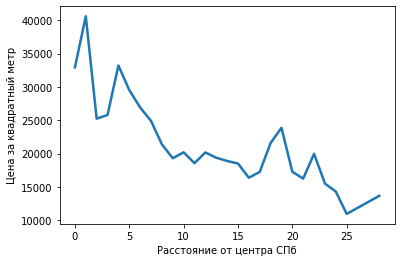

In [124]:
sns.lineplot(data=pivot_table_spb['std'], linewidth=2.5)
plt.xlabel('Расстояние от центра СПб')
plt.ylabel('Цена за квадратный метр')

Text(0, 0.5, 'Цена за квадратный метр')

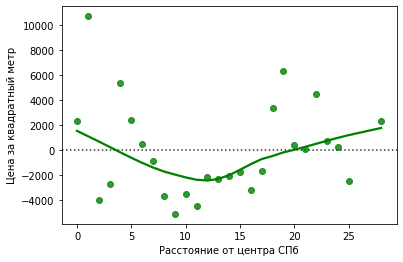

In [125]:
# lineplot - не подошел. Отрисовано не понятно. Характернвя точка угадывается в районе 10 км

# пробуем residplot

sns.residplot(x=pivot_table_spb.index, y=pivot_table_spb['std'], lowess=True, color="g") 
plt.xlabel('Расстояние от центра СПб')
plt.ylabel('Цена за квадратный метр')

#### Вывод: Центральную зону города можно определить радиусом 10 км.  Это точка 'перегиба'- минимума

### Задача: Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

In [126]:
# выделяем центральный сегмент СПб
Central_Radius = 10 #км
df_spb_central = df_spb.query('distance_citycenters_km <=@Central_Radius')

# оставим только нужные колонки для простроения таблицы корреляции
string_columns = 'distance_citycenters_km,total_area,floor,ceiling_height,year_exposition,price_per_meter'
list_columns = string_columns.split(',')
df_spb_central = df_spb_central[list_columns]

#удалим пропуски
#df_spb_central.dropna() - оказалось лишним, так как "Compute pairwise correlation of columns, excluding NA/null values.""

In [127]:
# получим таблицу корреляции
df_spb_central_corr = df_spb_central.corr()
df_spb_central_corr['price_per_meter_R10'] = df_spb_central_corr['price_per_meter']

In [128]:
# выделяем весь СПб включая центр
df_spb_all = df_spb[list_columns]
df_spb_all_corr = df_spb_all.corr()
df_spb_all_corr['price_per_meter_all'] = df_spb_all_corr['price_per_meter']
df_spb_all_corr = df_spb_all_corr['price_per_meter_all'] 

In [129]:
# склеиваем таблицы по индексу
df_temp = df_spb_central_corr.join(df_spb_all_corr, how='outer')

# отбрасываем лишнии колонки
listcol = ['price_per_meter_R10','price_per_meter_all']
df_temp = df_temp[listcol]
# разукрашиваем
df_temp.style.background_gradient('coolwarm')

,price_per_meter_R10,price_per_meter_all
distance_citycenters_km,-0.225796,-0.29264
total_area,-0.295219,-0.266305
floor,0.160852,0.178304
ceiling_height,0.134737,0.155114
year_exposition,0.180932,0.175309
price_per_meter,1,1


##### Вывод: На удельную стоимость (цена за квадратный метр) квартиры в центре ( радиус 10 км) наибольшее влияние оказывает общая площадь и этажность. При движении за радиус 10 км, начинает влиять фактор зависимости  удаленности от центра, при этом зависимость от этажности растет,  зависимость от высота потолков также увеличиватся (рост цены). В центре же высота потолков менее важна. Дата размещения оценивалась по годам публикации, характер зависимости в центре и в целом по городу одинаков. То есть цены в центре и по всему городу меняются во времени приблизительно одинаково.

### Шаг 5. Общий вывод

# - **Краткий обзор проведённой работы**

Были оценены и обработаны исходные данные. Частично восстановлены пропущенные значения в данных по расстоянию населенных пунктов до центра СПб и до аэропорта. Были уберите редкие и выбивающиеся значения.

Изучено влияние следующих параметров на формирование цены: общая площадь, число комнат, высота потолков. 

- **Главные выводы:**
- среднее время продажи оценено в 60 дней. Соответственно можно считать, что продажа прошла быстро если она заняла менее месяца (это 25% всех продаж). Необычно долгие продажи - это продажи время которых превышает 140 дней.Экстремально долгие продажи от 300 дней и более - до 1500 дней.
- с увеличением расстояния от центра падает цена за квадратный метр площади. На графике видно падение цены со 100 000 руб в центре 10 км радиуса до 50 000 руб при удалении на 60 км от центра.
- однокомнатные квартиры ценятся выше всего за квадратный метр. На графике видно, что цена может снизиться на четверть (25%) с ростом количества комнат.
- первый и последниий этажи не пользуются спросом по сравнению со средними этажами. Падение в цене за квадратный метр может составить 18%
- цены были достаточно стабильны с 2015 по 2018 год. Колебания цены были около 2%. Но в 2019 году цены начились резко подниматься. Прирост по сравнению с 2018 годом составил 6.8%.
- в июле и в декабре видны минимумы по цене. Но разброс цен по месяцам не более 5%
- среди 10 населенных пунктов с наинаиболее часто встречаемыми объявлениями, можно выделить максимум = это Пушкин (15500 руб) и минимум это - Всеволжск (11100 руб)
- центральную зону города можно определить радиусом  10 км.  Точка "перегиба"
- На удельную стоимость (цена за квадратный метр) квартиры в центре ( радиус 10 км) наибольшее влияние оказывает общая площадь и этажность. При движении за радиус 10 км, начинает влиять фактор зависимости  удаленности от центра, при этом зависимость от этажности растет,  зависимость от высота потолков также увеличиватся (рост цены). В центре же высота потолков менее важна. Дата размещения оценивалась по годам публикации, характер зависимости в центре и в целом по городу одинаков. То есть цены в центре и по всему городу меняются во времени приблизительно одинаково.


**Рекомендации для улучшения ввода данных автоматизированной системы:**
- Для бролее качественного прогнозирования, необходимо исключить появление данных с пропущенными данными. 
- Исключить появления экстремальных данных в полях: этаж, площадь, высота потолков, цена. 
